# SE ResNet

# Import Libraries

In [1]:
import os
import skimage
from skimage import io, transform
import math
import keras
import numpy as np
import tensorflow as tf
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D,Lambda,add,Reshape,concatenate, BatchNormalization,GlobalAveragePooling2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
from keras.regularizers import l2
%matplotlib inline

import keras.backend as K
K.set_learning_phase(1)

Using TensorFlow backend.


In [35]:
import numpy as np
import os
import time
from imagenet_utils import preprocess_input
from keras.layers import Input
from keras.models import Model
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

/Users/hardika/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Import Dataset

In [36]:
PATH = os.getcwd()

In [37]:
data_path = PATH + '/FULL_FACE_TRAIN'

In [38]:
data_dir_list = os.listdir(data_path)

In [39]:
img_data_list=[]

In [40]:
for dataset in data_dir_list:
	img_list=os.listdir(data_path+'/'+ dataset)
	print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
	for img in img_list:
		img_path = data_path + '/'+ dataset + '/'+ img
		img = image.load_img(img_path, target_size=(224, 224))
		x = image.img_to_array(img)
		x = np.expand_dims(x, axis=0)
		x = preprocess_input(x)
#		x = x/255
		#print('Input image shape:', x.shape)
		img_data_list.append(x)   

Loaded the images of dataset-Surprise face cropped

Loaded the images of dataset-Disgust face cropped

Loaded the images of dataset-Happy face cropped

Loaded the images of dataset-Contempt face cropped

Loaded the images of dataset-Angry face cropped

Loaded the images of dataset-Sad face cropped

Loaded the images of dataset-Fear face cropped



In [41]:
img_data = np.array(img_data_list) # takes time"
        
        # To bring data in the form (no. of images, row, col, channels)
        #print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
img_data=img_data[0]
       # print (img_data.shape) 

In [42]:
num_classes = 7
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

In [43]:
labels[0:540]=0
labels[540:880]=1
labels[880:1495]=2
labels[1495:1611]=3
labels[1611:2043]=4
labels[2043:2363]=5
labels[2363:2600]=6

In [44]:
names = ['Surprised face','Sad face','Happy face','Fear face','Disgust face','Contempt face','Angry face']

In [45]:
Y = np_utils.to_categorical(labels, num_classes)

# Shuffling and splitting

In [46]:
x,y = shuffle(img_data,Y, random_state=2) # TAKES TIME 
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2) 

# Code for Modified ResNet

In [47]:
def se_identity_block(X, filters, r=16):
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters = F2, kernel_size = (3, 3), strides = (1,1), padding = 'same')(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = BatchNormalization(axis=3)(X)
    
    X_increase = X
    X = GlobalAveragePooling2D(data_format='channels_last')(X)
    X = Reshape([1,1,F3])(X)
    X = Conv2D(filters = F3//r, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = Activation('sigmoid')(X)
    X = layers.add([keras.layers.multiply([X,X_increase]),X_shortcut])
    X = Activation('relu')(X)

    return X

In [48]:
def se_convolutional_block(X, filters, s = 2, r=16):

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides = (s,s), padding='valid')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2, (3, 3), strides = (1, 1), padding='same')(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides = (1, 1), padding='valid')(X)
    X = BatchNormalization(axis = 3)(X)

    X_increase = X
    X = GlobalAveragePooling2D(data_format='channels_last')(X)
    X = Reshape([1,1,F3])(X)
    X = Conv2D(filters = F3//r, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = Activation('relu')(X)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid')(X)
    X = Activation('sigmoid')(X)
    X_proj = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid')(X_shortcut)
    X_proj = BatchNormalization(axis = 3)(X_proj)
    X = layers.add([keras.layers.multiply([X,X_increase]),X_proj])
    X = Activation('relu')(X)
    
    return X

In [49]:
def SE_ResNet(input_shape = (224, 224,3)):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides = (2, 2))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2),padding='same')(X)

    X = se_convolutional_block(X, filters = [64, 64, 256],  s = 1)
    X = se_identity_block(X, [64, 64, 256])
    X = se_identity_block(X, [64, 64, 256])

    X = se_convolutional_block(X, filters=[128,128,512], s = 2)
    X = se_identity_block(X, filters=[128,128,512])
    X = se_identity_block(X, filters=[128,128,512])
    X = se_identity_block(X, filters=[128,128,512])

    X = se_convolutional_block(X, filters=[256, 256, 1024], s = 2)
    X = se_identity_block(X, filters=[256, 256, 1024])
    X = se_identity_block(X, filters=[256, 256, 1024])
    X = se_identity_block(X, filters=[256, 256, 1024])
    X = se_identity_block(X, filters=[256, 256, 1024])
    X = se_identity_block(X, filters=[256, 256, 1024])

    X = se_convolutional_block(X, filters=[512, 512, 2048], s = 2)
    X = se_identity_block(X, filters=[512, 512, 2048])
    X = se_identity_block(X, filters=[512, 512, 2048])

    X = AveragePooling2D((7,7), strides=(1,1))(X)
    X = Flatten()(X)
    X = Dense(7, activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [50]:
model = SE_ResNet(input_shape = (224, 224, 3))


In [51]:

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [52]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
hist = model.fit(X_train, y_train,epochs = 25, batch_size = 16,validation_data=(X_test,y_test), shuffle = True)

Train on 1820 samples, validate on 780 samples
Epoch 1/25
1820/1820 [==============================] - 1756s 965ms/step - loss: 2.4911 - acc: 0.2984 - val_loss: 2.1475 - val_acc: 0.3910
Epoch 2/25
1820/1820 [==============================] - 1780s 978ms/step - loss: 2.2486 - acc: 0.3923 - val_loss: 1.5197 - val_acc: 0.4705
Epoch 3/25
1820/1820 [==============================] - 1739s 956ms/step - loss: 1.2928 - acc: 0.5610 - val_loss: 0.9701 - val_acc: 0.6282
Epoch 4/25
1820/1820 [==============================] - 1746s 960ms/step - loss: 0.8716 - acc: 0.6940 - val_loss: 0.7753 - val_acc: 0.7244
Epoch 5/25
1820/1820 [==============================] - 1732s 952ms/step - loss: 0.6330 - acc: 0.8071 - val_loss: 0.5138 - val_acc: 0.8423
Epoch 6/25
1820/1820 [==============================] - 1711s 940ms/step - loss: 0.3657 - acc: 0.8714 - val_loss: 0.3794 - val_acc: 0.8910
Epoch 7/25
1820/1820 [==============================] - 1735s 953ms/step - loss: 0.3056 - acc: 0.9055 - val_loss: 0.354

# Saving Model

In [54]:
model.save('/Users/hardika/Downloads/PROJECT/Transfer-Learning-in-keras---custom-data-master/SENET_WEIGHTS.h5')

In [55]:
from keras.models import load_model

In [56]:
savedmodel=load_model('/Users/hardika/Downloads/PROJECT/Transfer-Learning-in-keras---custom-data-master/SENET_WEIGHTS.h5')

In [57]:
savedmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [58]:
Y_pred = savedmodel.predict(X_test)

In [59]:
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)


[2 4 2 4 5 2 0 1 1 2 5 2 4 4 0 6 1 5 4 2 5 1 1 1 4 4 6 5 4 4 6 6 0 5 1 4 2
 1 0 2 0 1 6 5 4 0 1 2 2 0 2 5 0 0 4 0 0 5 1 1 4 6 5 5 4 4 4 2 5 6 5 4 0 1
 0 0 2 2 2 5 2 3 2 2 0 5 4 4 4 4 5 2 2 0 0 6 2 4 6 1 4 6 4 0 0 6 6 2 4 1 0
 5 1 2 6 4 0 4 6 2 0 0 0 2 0 5 1 4 0 4 0 0 5 2 1 0 2 2 1 1 6 0 4 6 3 2 2 0
 2 1 2 3 0 0 0 2 6 4 6 4 0 2 2 2 6 5 6 5 2 1 0 6 2 2 1 0 5 2 4 2 4 3 1 5 6
 5 1 2 4 2 4 1 1 1 2 2 0 0 1 2 4 5 5 4 2 1 2 2 5 0 2 4 0 4 0 2 2 4 4 0 0 5
 4 5 4 6 2 3 1 5 5 0 5 2 4 2 2 0 2 4 0 1 2 3 4 5 1 5 3 0 2 5 5 2 2 0 0 0 6
 5 3 5 0 2 2 3 2 6 4 1 0 0 5 1 1 6 4 0 4 2 5 4 3 3 6 0 1 3 4 3 5 4 0 4 4 2
 0 0 5 2 4 3 6 2 6 0 1 0 2 0 4 0 4 5 4 1 4 0 5 2 5 2 6 0 2 0 0 2 2 0 4 4 2
 4 2 0 0 0 1 4 4 3 1 5 0 4 5 5 0 6 0 1 2 2 5 0 2 0 5 2 2 5 4 6 2 0 5 4 5 0
 3 5 5 2 5 4 1 1 4 2 1 1 4 2 5 5 2 2 0 1 6 2 0 4 6 1 0 1 2 5 2 1 5 0 2 6 4
 0 6 4 2 4 5 4 2 2 3 2 4 2 2 5 1 5 2 2 2 6 2 3 0 2 1 4 2 2 2 0 5 2 0 5 5 1
 0 2 5 4 5 4 2 4 0 4 6 0 4 5 1 0 3 0 0 5 1 1 4 2 2 5 2 0 1 5 0 3 4 0 1 5 0
 2 2 4 5 3 6 0 1 0 4 5 2 

In [61]:
from sklearn.metrics import classification_report,confusion_matrix
import itertools
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=names))

                precision    recall  f1-score   support

Surprised face       1.00      1.00      1.00       157
      Sad face       0.99      1.00      0.99        96
    Happy face       1.00      1.00      1.00       192
     Fear face       1.00      0.91      0.95        33
  Disgust face       0.97      0.99      0.98       122
 Contempt face       1.00      0.99      1.00       113
    Angry face       1.00      1.00      1.00        67

   avg / total       0.99      0.99      0.99       780



In [62]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       # cm=round(cm,3)
        
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[157   0   0   0   0   0   0]
 [  0  96   0   0   0   0   0]
 [  0   0 192   0   0   0   0]
 [  0   0   0  30   3   0   0]
 [  0   1   0   0 121   0   0]
 [  0   0   0   0   1 112   0]
 [  0   0   0   0   0   0  67]]


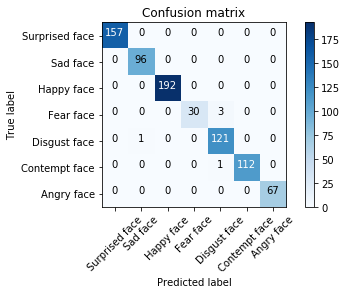

In [63]:
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))
plot_confusion_matrix(cnf_matrix, classes=names, normalize=False,title='Confusion matrix')
#plt.figure()
plt.show()

# PLOTTING

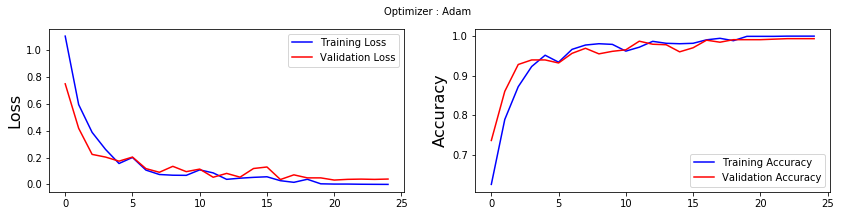

In [78]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], 'b', label='Training Loss')
plt.plot(hist.history['val_loss'], 'r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], 'b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], 'r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [79]:
from sklearn.metrics import classification_report,confusion_matrix
import itertools

In [80]:
Y_pred = model.predict(X_test)

In [81]:
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)


[2 4 2 4 5 2 0 1 1 2 5 2 4 4 0 6 1 5 4 2 5 1 1 1 4 4 6 5 4 4 6 6 0 5 1 4 2
 1 0 2 0 1 6 5 4 0 1 2 2 0 2 5 0 0 4 0 0 5 1 1 4 6 5 5 4 4 4 2 5 6 5 4 0 1
 0 0 2 2 2 5 2 3 2 2 0 5 4 4 4 4 5 2 2 0 0 6 2 4 6 1 4 6 4 0 0 6 6 2 4 1 0
 5 1 2 6 4 0 4 6 2 0 0 0 2 0 5 1 5 0 4 0 0 5 2 1 0 2 2 1 1 6 0 4 6 3 2 2 0
 2 1 2 3 0 0 0 2 6 4 6 4 0 2 2 2 6 5 6 5 2 1 0 6 2 2 1 0 5 2 4 2 4 3 1 5 6
 5 1 2 4 2 4 1 1 1 2 2 0 0 1 2 4 5 5 4 2 1 2 2 5 0 2 4 0 4 0 2 2 4 4 0 0 5
 4 5 4 6 2 3 1 5 5 0 5 2 4 2 2 0 2 4 0 1 2 3 4 5 1 5 3 0 2 5 5 2 2 0 0 0 6
 5 3 5 0 2 2 3 2 6 4 1 0 0 5 1 1 6 4 0 4 2 5 4 3 3 6 0 1 3 4 3 5 4 0 4 4 2
 0 0 5 2 4 3 6 2 6 0 1 0 2 0 4 0 4 5 4 1 4 0 5 2 5 2 6 0 2 0 0 2 2 0 4 4 2
 4 2 0 0 0 1 4 4 3 1 5 0 4 5 5 0 6 0 1 2 2 5 0 2 0 5 2 2 5 4 6 2 0 5 4 5 0
 3 5 5 2 5 4 1 1 4 2 1 1 4 2 5 5 2 2 0 1 6 2 0 4 6 1 0 1 2 5 2 1 5 0 2 6 4
 0 6 4 2 4 5 4 2 2 3 2 4 2 2 5 1 5 2 2 2 6 2 3 0 2 1 4 2 2 2 0 5 2 0 5 5 1
 0 2 5 4 5 4 2 4 0 4 6 0 4 5 1 0 3 0 0 5 1 1 4 2 2 5 2 0 1 5 0 3 4 0 1 5 0
 2 2 4 5 3 6 0 1 0 4 5 2 

In [82]:
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=names))

                precision    recall  f1-score   support

Surprised face       1.00      1.00      1.00       157
      Sad face       0.99      1.00      0.99        96
    Happy face       1.00      1.00      1.00       192
     Fear face       1.00      0.91      0.95        33
  Disgust face       0.98      1.00      0.99       122
 Contempt face       0.99      1.00      1.00       113
    Angry face       1.00      0.97      0.98        67

   avg / total       0.99      0.99      0.99       780



In [83]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
       # cm=round(cm,3)
        
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[157   0   0   0   0   0   0]
 [  0  96   0   0   0   0   0]
 [  0   0 192   0   0   0   0]
 [  0   0   0  30   3   0   0]
 [  0   0   0   0 122   0   0]
 [  0   0   0   0   0 113   0]
 [  0   1   0   0   0   1  65]]


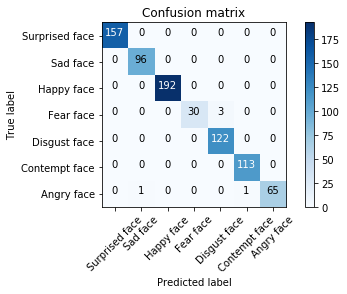

In [84]:
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))
plot_confusion_matrix(cnf_matrix, classes=names, normalize=False,title='Confusion matrix')
#plt.figure()
plt.show()
        